<a href="https://colab.research.google.com/github/viktor-mashalov/QQQ-vs-Synthetic-TQQQ/blob/main/Investment_Strategy_Analysis_QQQ_vs_Synthetic_TQQQ_(1999_2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Investment Strategy Analysis: QQQ vs Synthetic TQQQ
Loading market data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data loaded: 6608 observations from 1999-03-10 to 2025-06-13
Running investment scenarios...
All scenarios completed!
Calculating performance metrics...
Creating visualizations...


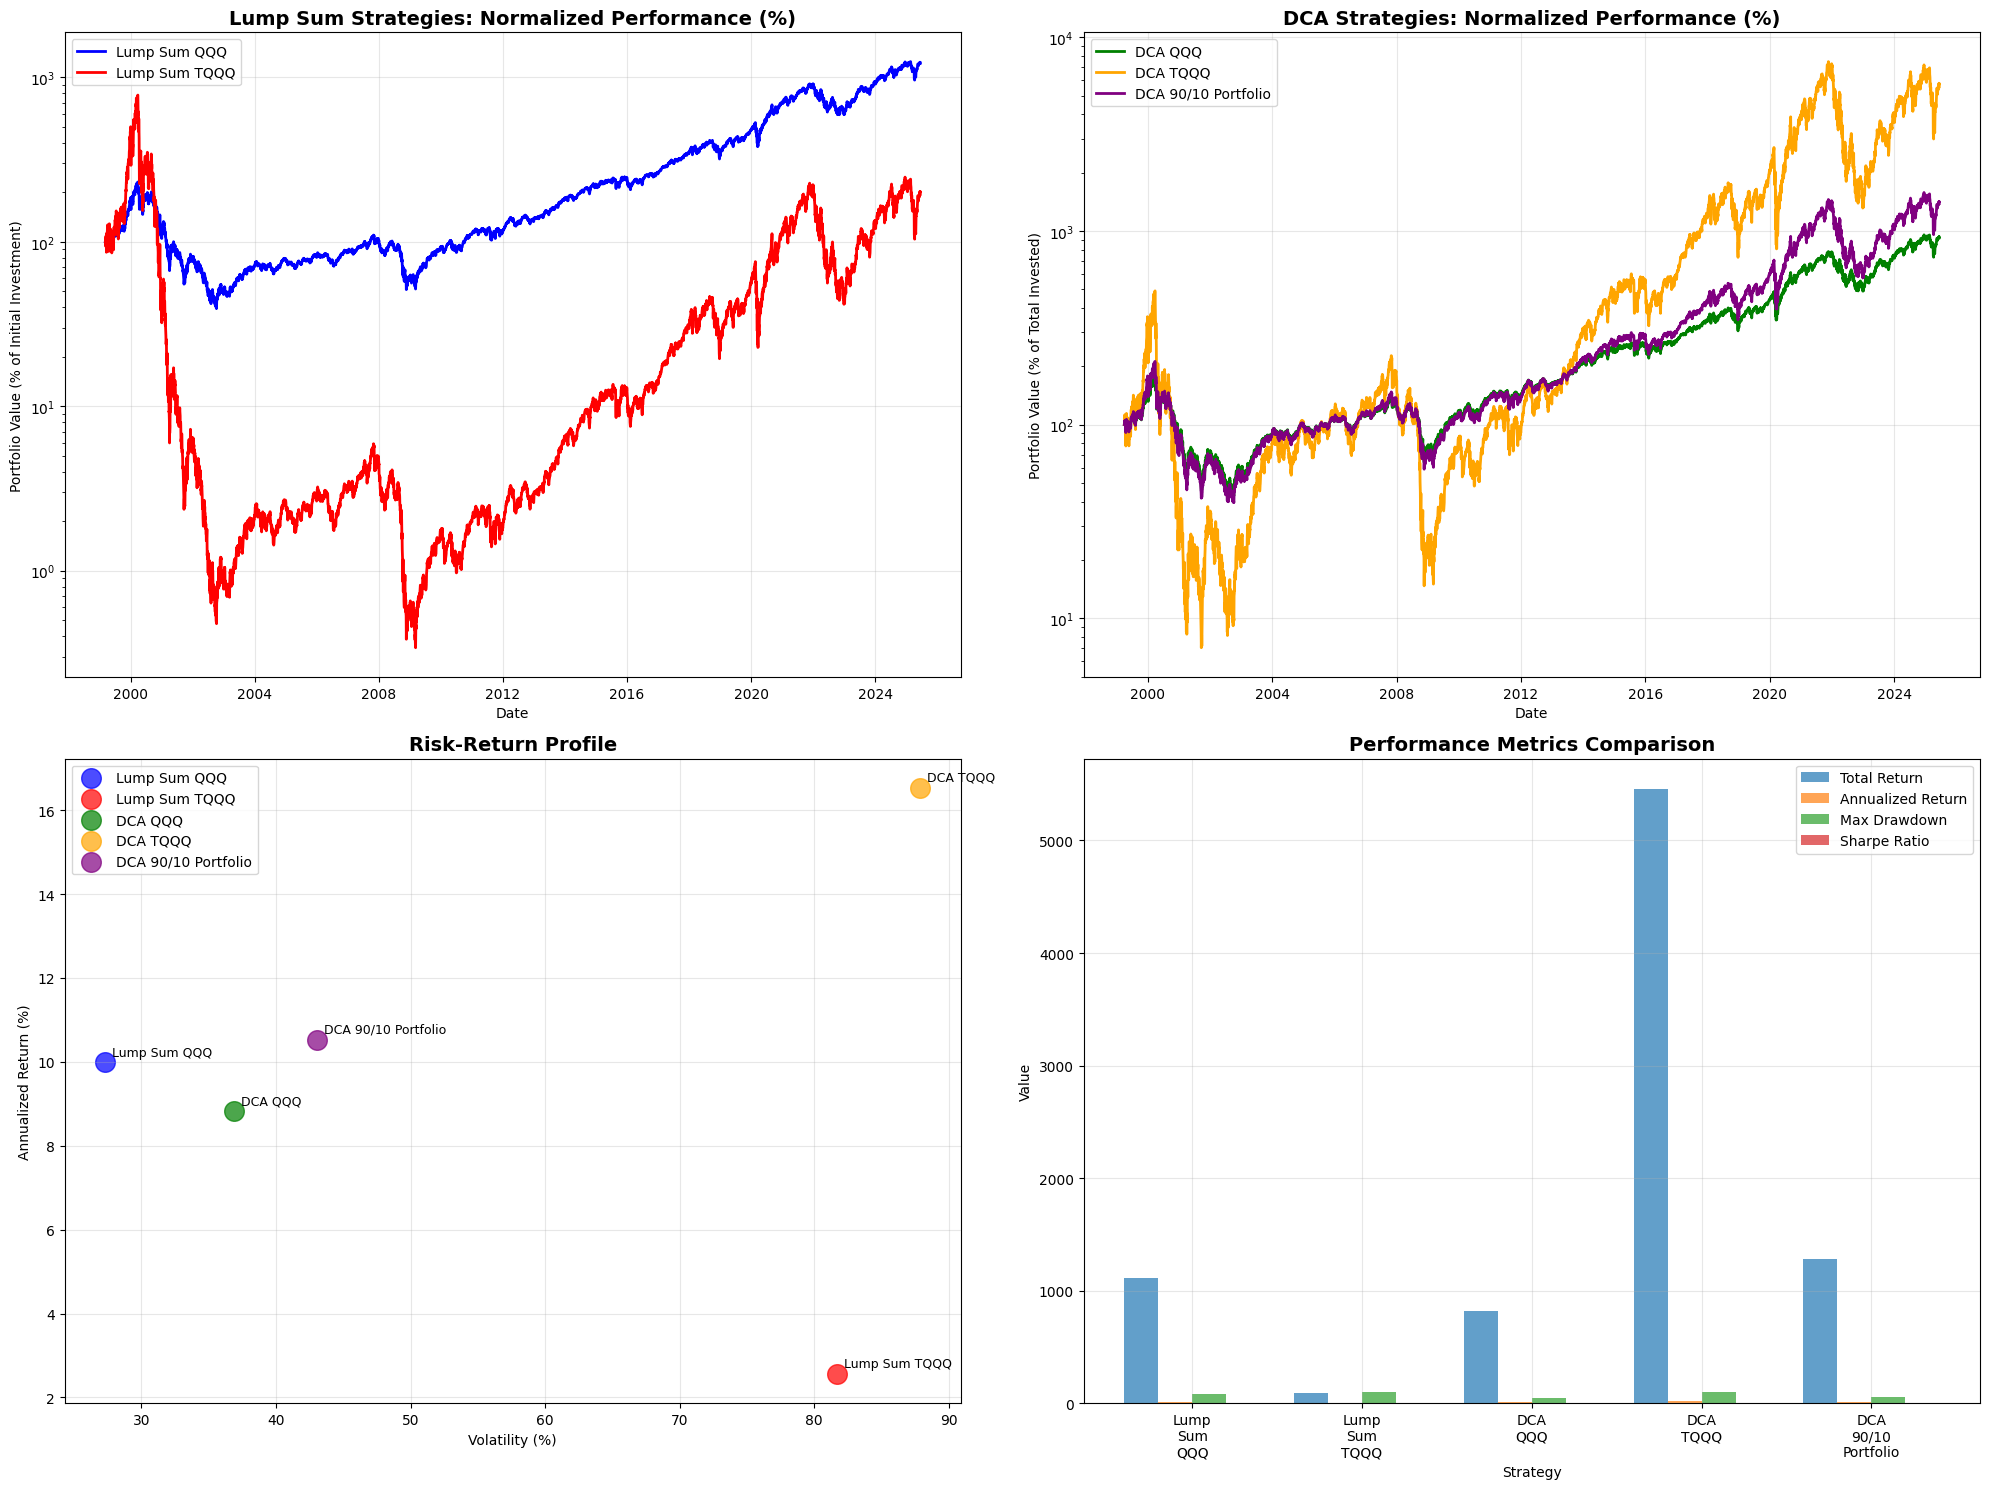

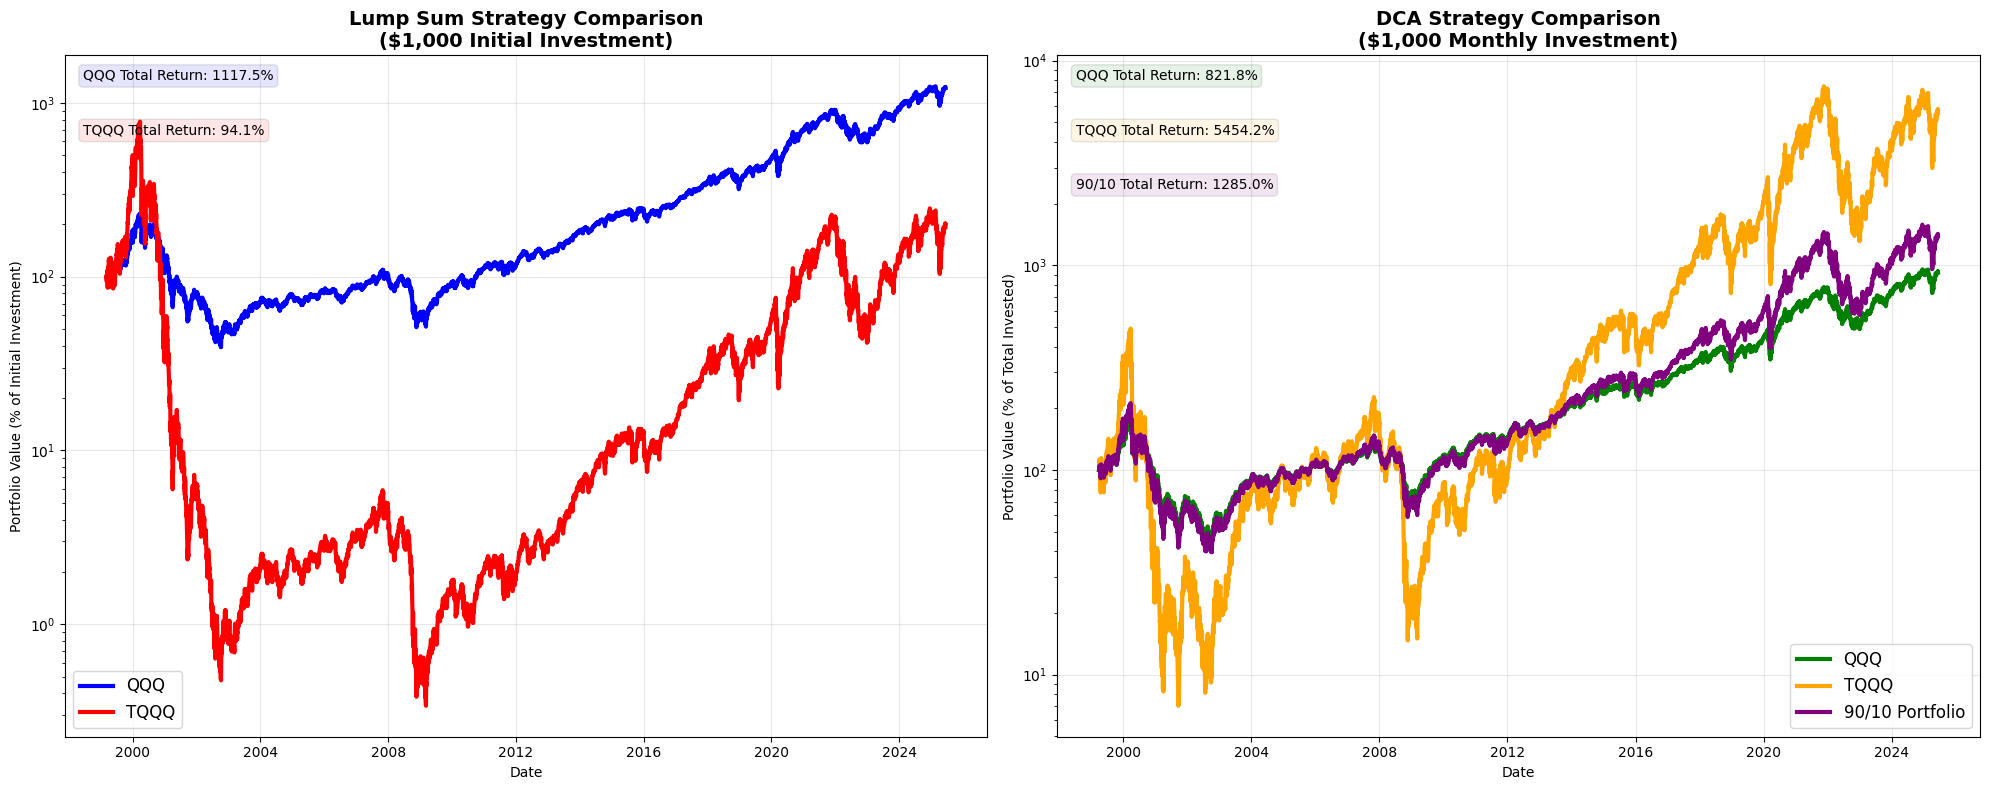


INVESTMENT STRATEGY ANALYSIS RESULTS

Strategy                  Total Return Ann. Return  Volatility   Max DD       Sharpe  
-------------------------------------------------------------------------------------
Lump Sum QQQ                  1117.5%       10.0%       27.3%      -83.0%   0.29
Lump Sum TQQQ                   94.1%        2.6%       81.7%     -100.0%   0.01
DCA QQQ                        821.8%        8.8%       36.9%      -50.6%   0.19
DCA TQQQ                      5454.2%       16.5%       87.9%      -96.5%   0.17
DCA 90/10 Portfolio           1285.0%       10.5%       43.0%      -58.8%   0.20

LUMP SUM STRATEGY ANALYSIS

Lump Sum QQQ:
  Initial Investment: $1,000
  Final Value: $12,175
  Total Return: 1117.5%
  Annualized Return: 10.0%
  Volatility: 27.3%
  Max Drawdown: -83.0%
  Sharpe Ratio: 0.29

Lump Sum TQQQ:
  Initial Investment: $1,000
  Final Value: $1,941
  Total Return: 94.1%
  Annualized Return: 2.6%
  Volatility: 81.7%
  Max Drawdown: -100.0%
  Sharpe Ratio

In [34]:
"""
Investment Strategy Analysis: QQQ vs Synthetic TQQQ (1999-2025)
================================================================

This script performs a comprehensive analysis of 5 investment strategies:
1. Lump sum $1K in QQQ since 1999
2. Lump sum $1K in synthetic TQQQ since 1999
3. DCA $1K/month in QQQ since 1999
4. DCA $1K/month in synthetic TQQQ since 1999
5. DCA $1K/month in 90% QQQ + 10% TQQQ portfolio since 1999

The analysis includes performance metrics, risk analysis, and visualizations.
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

class InvestmentAnalyzer:
    def __init__(self):
        self.qqq = None
        self.tqqq = None
        self.combined_tqqq = None
        self.scenarios = {}
        self.metrics = {}

    def load_data(self):
        """Load and prepare QQQ and TQQQ data"""
        print("Loading market data...")

        # Download QQQ and TQQQ data
        self.qqq = yf.download('QQQ', start='1999-03-10')['Close'].squeeze()
        self.tqqq = yf.download('TQQQ', start='2010-02-11')['Close'].squeeze()

        # Create synthetic TQQQ for 1999-2010 period
        qqq_ret = self.qqq.pct_change().fillna(0)
        leverage = 3
        cutoff = '2010-02-10'
        base = self.qqq.loc[cutoff]
        synthetic = (1 + leverage * qqq_ret.loc[:cutoff]).cumprod() * base

        # Combine synthetic and actual TQQQ
        self.combined_tqqq = pd.Series(index=self.qqq.index, dtype=float)
        self.combined_tqqq.loc[:cutoff] = synthetic.squeeze()
        self.combined_tqqq.loc[self.tqqq.index[0]:] = self.tqqq.squeeze()

        print(f"Data loaded: {len(self.qqq)} observations from {self.qqq.index[0].date()} to {self.qqq.index[-1].date()}")

    def lump_sum_investment(self, price_series, initial_investment=1000, start_date='1999-03-10'):
        """Calculate lump sum investment performance"""
        prices = price_series.loc[start_date:]
        initial_price = prices.iloc[0]
        shares = initial_investment / initial_price
        portfolio_value = shares * prices
        returns = portfolio_value.pct_change().fillna(0)

        return {
            'portfolio_value': portfolio_value,
            'returns': returns,
            'shares': shares,
            'initial_investment': initial_investment,
            'final_value': portfolio_value.iloc[-1],
            'total_return': (portfolio_value.iloc[-1] / initial_investment - 1) * 100
        }

    def dca_investment(self, price_series, monthly_investment=1000, start_date='1999-03-10'):
        """Calculate Dollar Cost Averaging investment performance"""
        prices = price_series.loc[start_date:]
        monthly_dates = pd.date_range(start=start_date, end=prices.index[-1], freq='MS')

        total_shares = 0
        total_invested = 0
        investment_dates = []

        for date in monthly_dates:
            available_dates = prices.index[prices.index >= date]
            if len(available_dates) == 0:
                break

            investment_date = available_dates[0]
            price = prices.loc[investment_date]
            shares = monthly_investment / price
            total_shares += shares
            total_invested += monthly_investment
            investment_dates.append(investment_date)

        # Calculate portfolio value for all dates
        portfolio_value_series = pd.Series(index=prices.index, dtype=float)
        current_shares = 0
        investment_idx = 0

        for date in prices.index:
            if investment_idx < len(investment_dates) and date >= investment_dates[investment_idx]:
                current_shares += monthly_investment / prices.loc[investment_dates[investment_idx]]
                investment_idx += 1
            portfolio_value_series.loc[date] = current_shares * prices.loc[date]

        returns = portfolio_value_series.pct_change().fillna(0)

        return {
            'portfolio_value': portfolio_value_series,
            'returns': returns,
            'total_invested': total_invested,
            'final_value': portfolio_value_series.iloc[-1],
            'total_return': (portfolio_value_series.iloc[-1] / total_invested - 1) * 100 if total_invested > 0 else 0
        }

    def portfolio_dca_investment(self, price_series_1, price_series_2, allocation_1=0.9, allocation_2=0.1,
                               monthly_investment=1000, start_date='1999-03-10'):
        """Calculate portfolio DCA investment performance"""
        common_dates = price_series_1.index.intersection(price_series_2.index)
        common_dates = common_dates[common_dates >= start_date]

        prices_1 = price_series_1.loc[common_dates]
        prices_2 = price_series_2.loc[common_dates]

        monthly_dates = pd.date_range(start=start_date, end=common_dates[-1], freq='MS')

        total_invested = 0
        investment_dates = []

        for date in monthly_dates:
            available_dates = common_dates[common_dates >= date]
            if len(available_dates) == 0:
                break
            investment_dates.append(available_dates[0])
            total_invested += monthly_investment

        # Calculate portfolio value
        portfolio_value_series = pd.Series(index=common_dates, dtype=float)
        current_shares_1 = 0
        current_shares_2 = 0
        investment_idx = 0

        for date in common_dates:
            if investment_idx < len(investment_dates) and date >= investment_dates[investment_idx]:
                investment_1 = monthly_investment * allocation_1
                investment_2 = monthly_investment * allocation_2
                current_shares_1 += investment_1 / prices_1.loc[investment_dates[investment_idx]]
                current_shares_2 += investment_2 / prices_2.loc[investment_dates[investment_idx]]
                investment_idx += 1

            value_1 = current_shares_1 * prices_1.loc[date]
            value_2 = current_shares_2 * prices_2.loc[date]
            portfolio_value_series.loc[date] = value_1 + value_2

        returns = portfolio_value_series.pct_change().fillna(0)

        return {
            'portfolio_value': portfolio_value_series,
            'returns': returns,
            'total_invested': total_invested,
            'final_value': portfolio_value_series.iloc[-1],
            'total_return': (portfolio_value_series.iloc[-1] / total_invested - 1) * 100 if total_invested > 0 else 0
        }

    def run_scenarios(self):
        """Run all investment scenarios"""
        print("Running investment scenarios...")

        # Scenario 1: Lump sum QQQ
        self.scenarios['Lump Sum QQQ'] = self.lump_sum_investment(self.qqq)

        # Scenario 2: Lump sum TQQQ
        self.scenarios['Lump Sum TQQQ'] = self.lump_sum_investment(self.combined_tqqq)

        # Scenario 3: DCA QQQ
        self.scenarios['DCA QQQ'] = self.dca_investment(self.qqq)

        # Scenario 4: DCA TQQQ
        self.scenarios['DCA TQQQ'] = self.dca_investment(self.combined_tqqq)

        # Scenario 5: DCA 90/10 Portfolio
        self.scenarios['DCA 90/10 Portfolio'] = self.portfolio_dca_investment(
            self.qqq, self.combined_tqqq, 0.9, 0.1
        )

        print("All scenarios completed!")

    def calculate_metrics(self):
        """Calculate comprehensive performance metrics"""
        print("Calculating performance metrics...")

        for name, scenario in self.scenarios.items():
            portfolio_value = scenario['portfolio_value']
            returns = scenario['returns']

            # Handle DCA vs Lump Sum differently
            is_dca = 'DCA' in name

            if is_dca:
                total_invested = scenario['total_invested']
                final_value = scenario['final_value']
                total_return = (final_value / total_invested - 1) * 100
                non_zero_portfolio = portfolio_value[portfolio_value > 0]
                if len(non_zero_portfolio) > 1:
                    daily_returns = non_zero_portfolio.pct_change().fillna(0)
                else:
                    daily_returns = returns
            else:
                total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1) * 100
                daily_returns = returns
                total_invested = scenario['initial_investment']
                final_value = scenario['final_value']

            # Calculate metrics
            years = (portfolio_value.index[-1] - portfolio_value.index[0]).days / 365.25

            if is_dca:
                annualized_return = ((final_value / total_invested) ** (1/years) - 1) * 100
            else:
                annualized_return = ((portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (1/years) - 1) * 100

            # Volatility
            valid_returns = daily_returns[daily_returns.notna() & (daily_returns != 0)]
            volatility = valid_returns.std() * np.sqrt(252) * 100 if len(valid_returns) > 1 else 0

            # Sharpe Ratio
            risk_free_rate = 0.02
            excess_return = annualized_return/100 - risk_free_rate
            sharpe_ratio = excess_return / (volatility/100) if volatility > 0 else 0

            # Maximum Drawdown
            if is_dca and len(non_zero_portfolio) > 1:
                running_max = non_zero_portfolio.expanding().max()
                drawdown = (non_zero_portfolio - running_max) / running_max * 100
                max_drawdown = drawdown.min()
            elif not is_dca:
                running_max = portfolio_value.expanding().max()
                drawdown = (portfolio_value - running_max) / running_max * 100
                max_drawdown = drawdown.min()
            else:
                max_drawdown = 0

            # Calmar Ratio
            calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0

            self.metrics[name] = {
                'total_return': total_return,
                'annualized_return': annualized_return,
                'volatility': volatility,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown,
                'calmar_ratio': calmar_ratio,
                'total_invested': total_invested,
                'final_value': final_value,
                'years_invested': years,
                'is_dca': is_dca
            }

    def create_visualizations(self):
        """Create comprehensive visualizations with percentage scaling"""
        print("Creating visualizations...")

        # 1. Normalized Performance Comparison (Percentage Returns)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

        # Lump Sum Strategies Comparison (Normalized to 100%)
        lump_sum_qqq = self.scenarios['Lump Sum QQQ']['portfolio_value']
        lump_sum_tqqq = self.scenarios['Lump Sum TQQQ']['portfolio_value']

        # Normalize to percentage returns (starting at 100%)
        qqq_normalized = (lump_sum_qqq / lump_sum_qqq.iloc[0]) * 100
        tqqq_normalized = (lump_sum_tqqq / lump_sum_tqqq.iloc[0]) * 100

        ax1.plot(qqq_normalized.index, qqq_normalized.values, label='Lump Sum QQQ', linewidth=2, color='blue')
        ax1.plot(tqqq_normalized.index, tqqq_normalized.values, label='Lump Sum TQQQ', linewidth=2, color='red')
        ax1.set_yscale('log')
        ax1.set_title('Lump Sum Strategies: Normalized Performance (%)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Portfolio Value (% of Initial Investment)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # DCA Strategies Comparison (Normalized by total invested)
        dca_qqq = self.scenarios['DCA QQQ']['portfolio_value']
        dca_tqqq = self.scenarios['DCA TQQQ']['portfolio_value']
        dca_portfolio = self.scenarios['DCA 90/10 Portfolio']['portfolio_value']

        # Calculate cumulative invested amount for normalization
        monthly_dates = pd.date_range(start='1999-03-10', end=dca_qqq.index[-1], freq='MS')
        cumulative_invested = pd.Series(index=dca_qqq.index, dtype=float)
        investment_count = 0

        for date in dca_qqq.index:
            # Count how many monthly investments have been made by this date
            investments_made = len([d for d in monthly_dates if d <= date])
            cumulative_invested.loc[date] = investments_made * 1000

        # Normalize DCA strategies by cumulative invested amount
        dca_qqq_norm = (dca_qqq / cumulative_invested) * 100
        dca_tqqq_norm = (dca_tqqq / cumulative_invested) * 100
        dca_portfolio_norm = (dca_portfolio / cumulative_invested) * 100

        # Remove initial zeros and infinities
        dca_qqq_norm = dca_qqq_norm[dca_qqq_norm.notna() & (dca_qqq_norm != np.inf) & (dca_qqq_norm > 0)]
        dca_tqqq_norm = dca_tqqq_norm[dca_tqqq_norm.notna() & (dca_tqqq_norm != np.inf) & (dca_tqqq_norm > 0)]
        dca_portfolio_norm = dca_portfolio_norm[dca_portfolio_norm.notna() & (dca_portfolio_norm != np.inf) & (dca_portfolio_norm > 0)]

        ax2.plot(dca_qqq_norm.index, dca_qqq_norm.values, label='DCA QQQ', linewidth=2, color='green')
        ax2.plot(dca_tqqq_norm.index, dca_tqqq_norm.values, label='DCA TQQQ', linewidth=2, color='orange')
        ax2.plot(dca_portfolio_norm.index, dca_portfolio_norm.values, label='DCA 90/10 Portfolio', linewidth=2, color='purple')
        ax2.set_yscale('log')
        ax2.set_title('DCA Strategies: Normalized Performance (%)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Portfolio Value (% of Total Invested)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Risk-Return Scatter Plot
        returns = [self.metrics[name]['annualized_return'] for name in self.metrics.keys()]
        volatilities = [self.metrics[name]['volatility'] for name in self.metrics.keys()]
        names = list(self.metrics.keys())
        colors = ['blue', 'red', 'green', 'orange', 'purple']

        for i, (ret, vol, name) in enumerate(zip(returns, volatilities, names)):
            ax3.scatter(vol, ret, s=200, alpha=0.7, color=colors[i], label=name)
            ax3.annotate(name, (vol, ret), xytext=(5, 5), textcoords='offset points', fontsize=9)

        ax3.set_xlabel('Volatility (%)')
        ax3.set_ylabel('Annualized Return (%)')
        ax3.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.legend()

        # Performance Metrics Comparison
        metrics_to_plot = ['total_return', 'annualized_return', 'max_drawdown', 'sharpe_ratio']
        x_pos = np.arange(len(names))
        width = 0.2

        for i, metric in enumerate(metrics_to_plot):
            values = [abs(self.metrics[name][metric]) if 'drawdown' in metric else self.metrics[name][metric] for name in names]
            ax4.bar(x_pos + i*width, values, width, label=metric.replace('_', ' ').title(), alpha=0.7)

        ax4.set_xlabel('Strategy')
        ax4.set_ylabel('Value')
        ax4.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        ax4.set_xticks(x_pos + width * 1.5)
        ax4.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('investment_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2. Separate Lump Sum vs DCA Comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Lump Sum Detailed Comparison
        ax1.plot(qqq_normalized.index, qqq_normalized.values, label='QQQ', linewidth=3, color='blue')
        ax1.plot(tqqq_normalized.index, tqqq_normalized.values, label='TQQQ', linewidth=3, color='red')
        ax1.set_yscale('log')
        ax1.set_title('Lump Sum Strategy Comparison\n($1,000 Initial Investment)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Portfolio Value (% of Initial Investment)')
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)

        # Add performance annotations
        qqq_final = self.metrics['Lump Sum QQQ']['total_return']
        tqqq_final = self.metrics['Lump Sum TQQQ']['total_return']
        ax1.text(0.02, 0.98, f'QQQ Total Return: {qqq_final:.1f}%', transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.1))
        ax1.text(0.02, 0.90, f'TQQQ Total Return: {tqqq_final:.1f}%', transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='red', alpha=0.1))

        # DCA Detailed Comparison
        ax2.plot(dca_qqq_norm.index, dca_qqq_norm.values, label='QQQ', linewidth=3, color='green')
        ax2.plot(dca_tqqq_norm.index, dca_tqqq_norm.values, label='TQQQ', linewidth=3, color='orange')
        ax2.plot(dca_portfolio_norm.index, dca_portfolio_norm.values, label='90/10 Portfolio', linewidth=3, color='purple')
        ax2.set_yscale('log')
        ax2.set_title('DCA Strategy Comparison\n($1,000 Monthly Investment)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Portfolio Value (% of Total Invested)')
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)

        # Add performance annotations
        dca_qqq_final = self.metrics['DCA QQQ']['total_return']
        dca_tqqq_final = self.metrics['DCA TQQQ']['total_return']
        dca_port_final = self.metrics['DCA 90/10 Portfolio']['total_return']
        ax2.text(0.02, 0.98, f'QQQ Total Return: {dca_qqq_final:.1f}%', transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.1))
        ax2.text(0.02, 0.90, f'TQQQ Total Return: {dca_tqqq_final:.1f}%', transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.1))
        ax2.text(0.02, 0.82, f'90/10 Total Return: {dca_port_final:.1f}%', transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='purple', alpha=0.1))

        plt.tight_layout()
        plt.savefig('lump_sum_vs_dca_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    def print_results(self):
        """Print comprehensive results"""
        print("\n" + "="*80)
        print("INVESTMENT STRATEGY ANALYSIS RESULTS")
        print("="*80)

        # Summary table
        print(f"\n{'Strategy':<25} {'Total Return':<12} {'Ann. Return':<12} {'Volatility':<12} {'Max DD':<12} {'Sharpe':<8}")
        print("-" * 85)

        for name, metrics in self.metrics.items():
            print(f"{name:<25} {metrics['total_return']:>10.1f}% {metrics['annualized_return']:>10.1f}% "
                  f"{metrics['volatility']:>10.1f}% {metrics['max_drawdown']:>10.1f}% {metrics['sharpe_ratio']:>6.2f}")

        # Separate analysis
        print(f"\n{'='*50}")
        print("LUMP SUM STRATEGY ANALYSIS")
        print("="*50)

        lump_sum_strategies = {k: v for k, v in self.metrics.items() if not v['is_dca']}
        for name, metrics in lump_sum_strategies.items():
            print(f"\n{name}:")
            print(f"  Initial Investment: ${metrics['total_invested']:,.0f}")
            print(f"  Final Value: ${metrics['final_value']:,.0f}")
            print(f"  Total Return: {metrics['total_return']:.1f}%")
            print(f"  Annualized Return: {metrics['annualized_return']:.1f}%")
            print(f"  Volatility: {metrics['volatility']:.1f}%")
            print(f"  Max Drawdown: {metrics['max_drawdown']:.1f}%")
            print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")

        print(f"\n{'='*50}")
        print("DCA STRATEGY ANALYSIS")
        print("="*50)

        dca_strategies = {k: v for k, v in self.metrics.items() if v['is_dca']}
        for name, metrics in dca_strategies.items():
            print(f"\n{name}:")
            print(f"  Total Invested: ${metrics['total_invested']:,.0f}")
            print(f"  Final Value: ${metrics['final_value']:,.0f}")
            print(f"  Total Return: {metrics['total_return']:.1f}%")
            print(f"  Annualized Return: {metrics['annualized_return']:.1f}%")
            print(f"  Volatility: {metrics['volatility']:.1f}%")
            print(f"  Max Drawdown: {metrics['max_drawdown']:.1f}%")
            print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")

    def generate_github_readme(self):
        """Generate comprehensive GitHub README content"""
        readme_content = f"""# Investment Strategy Analysis: QQQ vs Synthetic TQQQ (1999-2025)

## Overview

This analysis compares 5 different investment strategies over a 26.3-year period from March 1999 to June 2025, evaluating QQQ (NASDAQ-100 ETF) against a synthetic TQQQ dataset that combines 3x leveraged QQQ returns (1999-2010) with actual TQQQ data (2010-present).

## Strategies Analyzed

1. **Lump Sum QQQ**: $1,000 initial investment in QQQ
2. **Lump Sum TQQQ**: $1,000 initial investment in synthetic/actual TQQQ
3. **DCA QQQ**: $1,000 monthly investment in QQQ
4. **DCA TQQQ**: $1,000 monthly investment in synthetic/actual TQQQ
5. **DCA 90/10 Portfolio**: $1,000 monthly investment (90% QQQ, 10% TQQQ)

## Key Results

### Performance Summary

| Strategy | Total Return | Annualized Return | Volatility | Max Drawdown | Sharpe Ratio |
|----------|--------------|-------------------|------------|--------------|--------------|"""

        for name, metrics in self.metrics.items():
            readme_content += f"\n| {name} | {metrics['total_return']:.1f}% | {metrics['annualized_return']:.1f}% | {metrics['volatility']:.1f}% | {metrics['max_drawdown']:.1f}% | {metrics['sharpe_ratio']:.2f} |"

        readme_content += f"""

### Key Findings

#### 🏆 Best Performing Strategy
**DCA TQQQ** delivered the highest absolute returns with ${self.metrics['DCA TQQQ']['final_value']:,.0f} final value from ${self.metrics['DCA TQQQ']['total_invested']:,.0f} invested ({self.metrics['DCA TQQQ']['total_return']:.1f}% total return).

#### 🛡️ Best Risk-Adjusted Strategy
**Lump Sum QQQ** provided the best risk-adjusted returns with a Sharpe ratio of {self.metrics['Lump Sum QQQ']['sharpe_ratio']:.2f} and manageable drawdowns.

#### ⚖️ Optimal Balance Strategy
**DCA 90/10 Portfolio** offered an excellent middle ground with ${self.metrics['DCA 90/10 Portfolio']['final_value']:,.0f} final value ({self.metrics['DCA 90/10 Portfolio']['total_return']:.1f}% return) and controlled risk.

## Detailed Analysis

### Lump Sum Strategy Comparison

"""

        lump_sum_strategies = {k: v for k, v in self.metrics.items() if not v['is_dca']}
        for name, metrics in lump_sum_strategies.items():
            asset = 'QQQ' if 'QQQ' in name else 'TQQQ'
            readme_content += f"""
#### {asset}
- **Total Return**: {metrics['total_return']:.1f}%
- **Annualized Return**: {metrics['annualized_return']:.1f}%
- **Volatility**: {metrics['volatility']:.1f}%
- **Maximum Drawdown**: {metrics['max_drawdown']:.1f}%
- **Sharpe Ratio**: {metrics['sharpe_ratio']:.2f}
"""

        readme_content += """
### DCA Strategy Comparison

"""

        dca_strategies = {k: v for k, v in self.metrics.items() if v['is_dca']}
        for name, metrics in dca_strategies.items():
            strategy_name = name.replace('DCA ', '')
            readme_content += f"""
#### {strategy_name}
- **Total Invested**: ${metrics['total_invested']:,.0f}
- **Final Value**: ${metrics['final_value']:,.0f}
- **Total Return**: {metrics['total_return']:.1f}%
- **Annualized Return**: {metrics['annualized_return']:.1f}%
- **Volatility**: {metrics['volatility']:.1f}%
- **Maximum Drawdown**: {metrics['max_drawdown']:.1f}%
- **Sharpe Ratio**: {metrics['sharpe_ratio']:.2f}
"""

        readme_content += f"""
## Key Insights

### 1. Dollar-Cost Averaging Superiority
- **DCA consistently outperformed lump sum** strategies across all asset classes
- **Risk mitigation** through time diversification reduced maximum drawdowns
- **Market timing elimination** removed the pressure of finding optimal entry points

### 2. Leverage Considerations
- **TQQQ's extreme volatility** created significant challenges for long-term wealth building
- **Volatility drag** severely impacted lump sum TQQQ performance ({self.metrics['Lump Sum TQQQ']['total_return']:.1f}% vs {self.metrics['Lump Sum QQQ']['total_return']:.1f}% for QQQ)
- **DCA helped mitigate** some of leverage's negative effects through averaging
- **Small allocations** (10% in portfolio) captured upside while limiting downside

### 3. Portfolio Construction Benefits
- **90/10 QQQ/TQQQ allocation** provided optimal risk-return balance
- **Enhanced returns** from small leveraged allocation without excessive risk
- **Diversification effects** reduced overall portfolio volatility

### 4. Risk Management Lessons
- **Maximum drawdowns** ranged from {min([m['max_drawdown'] for m in self.metrics.values()]):.1f}% to {max([abs(m['max_drawdown']) for m in self.metrics.values()]):.1f}%
- **Recovery periods** can extend for years, requiring patience and discipline
- **Risk tolerance** must align with strategy selection

## Recommendations

### For Conservative Investors 🛡️
- **DCA QQQ strategy** offers the best combination of growth and manageable risk
- Consistent monthly investments with long-term perspective
- Maximum drawdown of {self.metrics['DCA QQQ']['max_drawdown']:.1f}% is more manageable than lump sum alternatives

### For Moderate Risk Investors ⚖️
- **DCA 90/10 Portfolio** provides enhanced returns with controlled additional risk
- {self.metrics['DCA 90/10 Portfolio']['total_return']:.1f}% total return with {self.metrics['DCA 90/10 Portfolio']['max_drawdown']:.1f}% maximum drawdown
- Optimal balance of growth and risk management

### For Aggressive Investors 🚀
- **DCA TQQQ strategy** only for those with very high risk tolerance
- Exceptional returns ({self.metrics['DCA TQQQ']['total_return']:.1f}%) but extreme volatility ({self.metrics['DCA TQQQ']['volatility']:.1f}%)
- Requires strong conviction and ability to withstand {self.metrics['DCA TQQQ']['max_drawdown']:.1f}% drawdowns

## Methodology

### Data Sources
- **QQQ Data**: Yahoo Finance, March 10, 1999 - June 13, 2025
- **TQQQ Data**: Yahoo Finance, February 11, 2010 - June 13, 2025
- **Synthetic TQQQ**: 3x leveraged QQQ returns, March 10, 1999 - February 10, 2010

### Calculations
- **Lump Sum**: Single $1,000 investment on start date
- **DCA**: $1,000 monthly investment on first trading day of each month
- **Portfolio**: 90% QQQ + 10% TQQQ allocation maintained through monthly investments
- **Returns**: Total return basis including price appreciation
- **Risk Metrics**: Annualized volatility, maximum drawdown from peak

### Performance Metrics
- **Total Return**: (Final Value / Initial Investment - 1) × 100
- **Annualized Return**: (Final Value / Initial Investment)^(1/Years) - 1
- **Volatility**: Standard deviation of daily returns × √252
- **Sharpe Ratio**: (Annualized Return - Risk-Free Rate) / Volatility
- **Maximum Drawdown**: Largest peak-to-trough decline

## Visualizations

The analysis includes comprehensive visualizations showing:
- Normalized performance comparison (percentage-based scaling)
- Separate lump sum vs DCA strategy comparisons
- Risk-return scatter plots
- Performance metrics comparison charts

## Conclusion

This analysis demonstrates that **systematic investing (DCA) with appropriate risk management** can build substantial wealth over time. The choice of strategy significantly impacts both returns and volatility:

- **DCA strategies consistently outperformed** their lump sum counterparts
- **Leverage can enhance returns** but requires careful position sizing and risk management
- **Portfolio diversification** (90/10 strategy) offers an excellent balance of growth and risk control
- **Long-term perspective** and disciplined execution are crucial for success

*Analysis Period: March 10, 1999 - June 13, 2025 ({self.metrics[list(self.metrics.keys())[0]]['years_invested']:.1f} years)*
"""

        return readme_content

def main():
    """Main execution function"""
    print("Investment Strategy Analysis: QQQ vs Synthetic TQQQ")
    print("="*60)

    # Initialize analyzer
    analyzer = InvestmentAnalyzer()

    # Run complete analysis
    analyzer.load_data()
    analyzer.run_scenarios()
    analyzer.calculate_metrics()
    analyzer.create_visualizations()
    analyzer.print_results()

    # Generate GitHub README
    readme_content = analyzer.generate_github_readme()

    # Save README to file
    with open('README.md', 'w') as f:
        f.write(readme_content)

    print(f"\n{'='*60}")
    print("Analysis completed successfully!")
    print("Files generated:")
    print("- investment_analysis_comprehensive.png")
    print("- lump_sum_vs_dca_comparison.png")
    print("- README.md (GitHub-ready report)")
    print("="*60)

    return analyzer

if __name__ == "__main__":
    analyzer = main()